<a href="https://colab.research.google.com/github/KhawajaMuddassar/object_detection-and-image-classification/blob/main/practical_aspects_of_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Class Activation Maps - CAMs**

Class Activation Maps (CAMs) are techniques used to visualize the important regions in an image that contribute to a model's prediction for a specific class. They help interpret deep learning models, particularly convolutional neural networks (CNNs), by highlighting the areas that influenced the classification decision.

Imagine a scenario where we have built a model that is able to make good predictions. However, the stakeholder that we are presenting the model to wants to understand the reason why the model predictions are as they are. A CAM comes in handy in this scenario.

***Types of CAMs***

**Standard CAM:** Directly utilizes the output from the last convolutional layer in a CNN. The weights from the final classification layer are used to weight the feature maps, useful for Visualizing which parts of an image are important for the final classification.

**Grad-CAM (Gradient-weighted Class Activation Mapping):**Enhances standard CAM by using the gradients of the target class with respect to the feature maps. This method provides more informative and detailed visualizations and Commonly used in more complex models to interpret decisions in real-time applications like medical imaging.

**Score-CAM:**Similar to Grad-CAM but does not require backpropagation of gradients. It computes the importance of each feature map by evaluating the model's score when the feature map is activated.Useful when dealing with models where gradient information may not be reliable, such as in certain generative models.


***High-Level Strategy for CAMs Generation:***


1.   Decide for which class you want to calculate the CAM and for which convolutional layer in the neural network you want to compute the CAM.
2.    Calculate the activations arising from any convolutional layer: let’s say the feature shape at a random convolution layer is 512 x 7 x 7
3.    Fetch the gradient values arising from this layer with respect to the class of interest. The output gradient shape is 256 x 512 x 3 x 3 (which is the shape of the convolutional tensor: that is, in-channels x out-channels x kernel-size x kernel-size)
4.     Compute the mean of the gradients within each output channel. The output shape is 512. In the following picture, we are calculating the mean in such a way that we have an output shape of 512 from an input shape of 256 x 512 x 3 x 3
5.     Calculate the weighted activation map, which is the multiplication of the 512 gradient means by the 512 activation channels. The output shape is 512 x 7 x 7
6.     Compute the mean (across 512 channels) of the weighted activation map to fetch an output of the shape 7 x 7
7.     Resize (upscale) the weighted activation map outputs to fetch an image of a size that is of the same size as the input. This is done so that we have an activation map that resembles the original image
8.    Overlay the weighted activation map onto the input image

The following diagram from the paper Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization (https://arxiv.org/abs/1610.02391) pictorially describes the preceding steps:

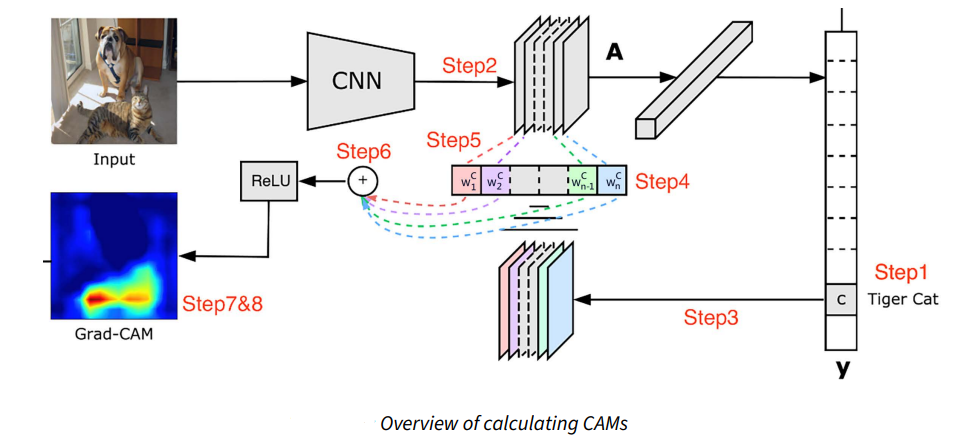

The key to the entire process lies in Step 5. We consider two aspects of the step:


*  If a certain pixel is important, then the CNN will have a large activation at those pixels
*   If a certain convolutional channel is important with respect to the required class, the gradients at that channel will be very large

On multiplying these two, we indeed end up with a map of importance across all the pixels



# **Implementing model to Predict whether a cell image indicates malaria**
The preceding strategy is implemented in code to understand the reason why the CNN model predicts that an image indicates the likelihood of an incident of malaria


In [ ]:
#  provide your respective Kaggle username and key
%%writefile kaggle.json
{"username":"your username","key":"kaggle key"}

Writing kaggle.json


In [ ]:
# Download the dataset and import the relevant packages
%pip install -q kaggle torch_snippets

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria
!unzip -qq cell-images-for-detecting-malaria.zip


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.6/204.6 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.0/99.0 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 87.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 84.9 MB/s eta 0:00:00
kaggle.json
Dataset URL: https://www.kaggle.com/datasets/iarunava/cell-images-for-dete

[10/04/24 02:03:04] INFO     20668                                                                                                ]8;id=446485;file://<ipython-input-7-457b7fbb1a3a>:47\<ipython-input-7-457b7fbb1a3a>]8;;\:]8;id=45362;file://<ipython-input-7-457b7fbb1a3a>:47#__init__:47\__init__:47]8;;\

                    INFO     6890                                                                                                 ]8;id=427292;file://<ipython-input-7-457b7fbb1a3a>:47\<ipython-input-7-457b7fbb1a3a>]8;;\:]8;id=564568;file://<ipython-input-7-457b7fbb1a3a>:47#__init__:47\__init__:47]8;;\

EPOCH: 1.000  trn_acc: 0.910  trn_loss: 0.239  val_acc: 0.951  val_loss: 0.163  (136.35s - 136.35s remaining)
EPOCH: 2.000  trn_acc: 0.946  trn_loss: 0.173  val_acc: 0.919  val_loss: 0.247  (271.94s - 0.00s remaining)
torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])


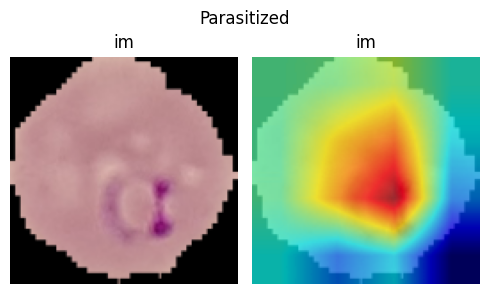

torch.Size([1, 64, 4, 4])


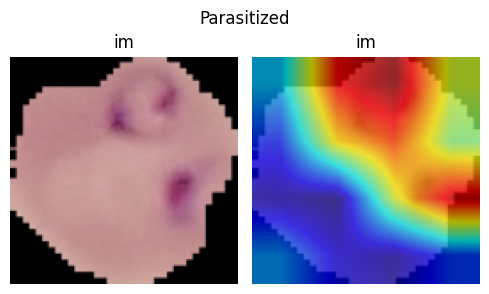

torch.Size([1, 64, 4, 4])


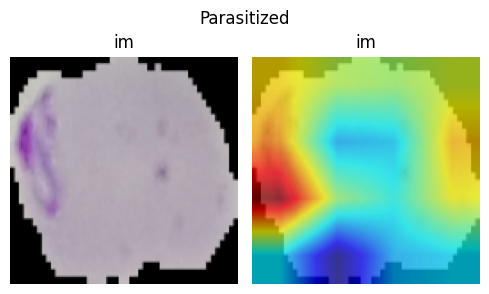

torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])


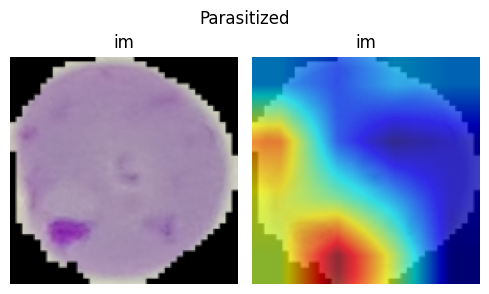

torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])


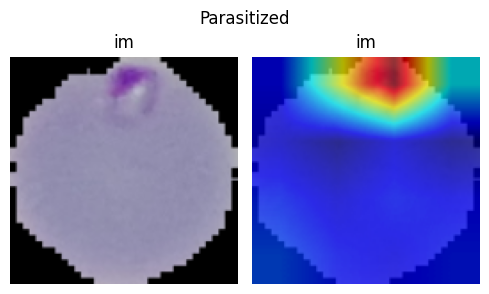

torch.Size([1, 64, 4, 4])


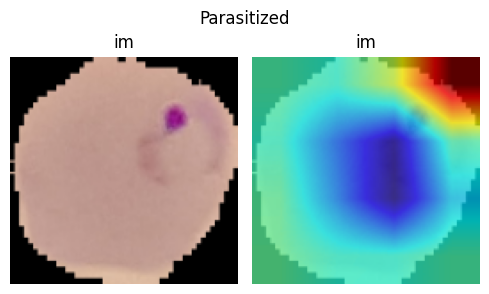

torch.Size([1, 64, 4, 4])


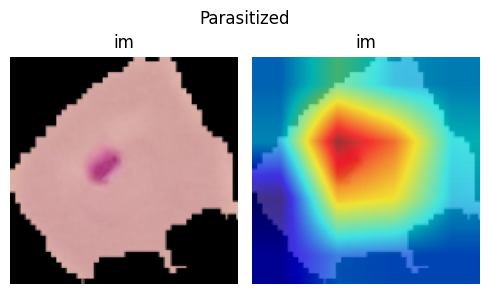

torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])


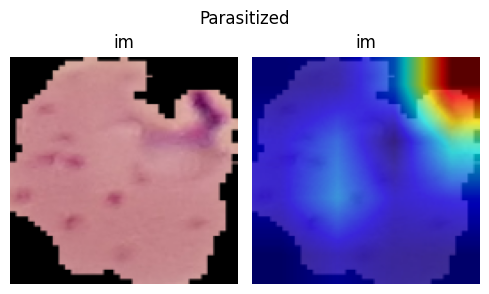

torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])


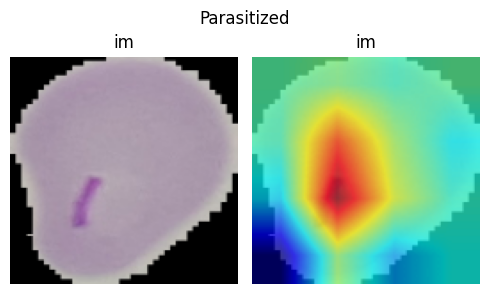

torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])


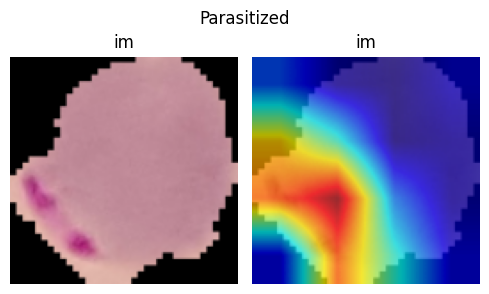

In [ ]:
import torch_snippets
from torch_snippets import *
from torchvision import transforms as T
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
import torch.nn as nn
from torch.optim import Adam, SGD
import torch.optim
from torch_snippets.torch_loader import Report
import cv2

#Specify the indices corresponding to the output classes
id2int = {'Parasitized': 0, 'Uninfected': 1}

# Perform pipeline of transformations on top of the input image
trn_tfms = T.Compose([
    T.ToPILImage(), # convert to PIL image
    T.Resize(128),  # Resize to 128 dims
    T.CenterCrop(128), # crop center
    T.ColorJitter(brightness=(0.95,1.05), # change randomly the brightness, contrast, saturation and hue of an image
                  contrast=(0.95,1.05),
                  saturation=(0.95,1.05),
                  hue=0.05),
    T.RandomAffine(5, translate=(0.01,0.1)), #Keep image center invariant
    T.ToTensor(), # Convert image to Tensor
    T.Normalize(mean=[0.5, 0.5, 0.5],  # Normalize it
                std=[0.5, 0.5, 0.5]),
])

# transformations to be done on the validation images
val_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(128),
    T.CenterCrop(128),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5],
                std=[0.5, 0.5, 0.5]),
])

# Define Class for  MalariaImages dataset
class MalariaImages(Dataset):
    def __init__(self, files, transform=None):
        self.files = files
        self.transform = transform
        logger.info(len(self))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, ix):
        fpath = self.files[ix]
        clss = fname(parent(fpath))
        img = read(fpath, 1)
        return img, clss

    def choose(self):
        return self[randint(len(self))]

    def collate_fn(self, batch):
        _imgs, classes = list(zip(*batch))
        if self.transform:
            imgs = [self.transform(img)[None] for img in _imgs]
        classes = [torch.tensor([id2int[clss]]) for clss in classes]
        imgs, classes = [torch.cat(i).to(device) for i in [imgs, classes]]
        return imgs, classes, _imgs

# Fetch the training and validation datasets and data loader
device = 'cuda' if torch.cuda.is_available() else 'cpu'
all_files = Glob('cell_images/*/*.png')
np.random.seed(10)
np.random.shuffle(all_files)

from sklearn.model_selection import train_test_split
trn_files, val_files = train_test_split(all_files, random_state=1)

trn_ds = MalariaImages(trn_files, transform=trn_tfms)
val_ds = MalariaImages(val_files, transform=val_tfms)
trn_dl = DataLoader(trn_ds, 32, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, 32, shuffle=False, collate_fn=val_ds.collate_fn)

# Define the MalariaClassifier model
def convBlock(ni, no):
    return nn.Sequential(
        nn.Dropout(0.2),
        nn.Conv2d(ni, no, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(no),
        nn.MaxPool2d(2),
    )

class MalariaClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            convBlock(3, 64),
            convBlock(64, 64),
            convBlock(64, 128),
            convBlock(128, 256),
            convBlock(256, 512),
            convBlock(512, 64),
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.Dropout(0.2),
            nn.ReLU(inplace=True),
            nn.Linear(256, len(id2int))
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def compute_metrics(self, preds, targets):
        loss = self.loss_fn(preds, targets)
        acc = (torch.max(preds, 1)[1] == targets).float().mean()
        return loss, acc

# Define the functions to train and validate a batch of data
def train_batch(model, data, optimizer, criterion):
    model.train()
    ims, labels, _ = data
    _preds = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_preds, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, labels, _ = data
    _preds = model(ims)
    loss, acc = criterion(_preds, labels)
    return loss.item(), acc.item()

#Train the model over increasing epochs
model = MalariaClassifier().to(device)
criterion = model.compute_metrics
optimizer = Adam(model.parameters(), lr=1e-3)
n_epochs = 2

log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')

    log.report_avgs(ex+1)

# Fetch the convolution layer in the fifth convBlock in the model
# we are fetching the fourth layer of the model and also the first two layers within convBlock, which happens to be the Conv2D layer
im2fmap = nn.Sequential(*(list(model.model[:5].children()) + list(model.model[5][:2].children())))

#adCAM function, which takes an input image and fetches the heatmap corresponding to activations of the image
def im2gradCAM(x):
    model.eval()
    logits = model(x)
    heatmaps = []
    activations = im2fmap(x)
    print(activations.shape)
    pred = logits.max(-1)[-1]
    # get the model's prediction
    model.zero_grad()
    # compute gradients with respect to model's most confident logit
    logits[0,pred].backward(retain_graph=True)
    # get the gradients at the required featuremap location
    # and take the avg gradient for every featuremap
    pooled_grads = model.model[-6][1].weight.grad.data.mean((1,2,3))
    # multiply each activation map with corresponding gradient average
    for i in range(activations.shape[1]):
        activations[:,i,:,:] *= pooled_grads[i]
    # take the mean of all weighted activation maps
    # (that has been weighted by avg. grad at each fmap)
    heatmap = torch.mean(activations, dim=1)[0].cpu().detach()
    return heatmap, 'Uninfected' if pred.item() else 'Parasitized'

# Define the upsampleHeatmap function to upsample the heatmap to a shape that corresponds to the shape of the image
 #de-normalizing the image and overlaying the heatmap on top of the image
SZ = 128
def upsampleHeatmap(map, img):
    m,M = map.min(), map.max()
    map = 255 * ((map-m) / (M-m))
    map = np.uint8(map)
    map = cv2.resize(map, (SZ,SZ))
    map = cv2.applyColorMap(255-map, cv2.COLORMAP_JET)
    map = np.uint8(map)
    map = np.uint8(map*0.7 + img*0.3)
    return map

# Apply above functions on a set of images
N = 20
_val_dl = DataLoader(val_ds, batch_size=N, shuffle=True, collate_fn=val_ds.collate_fn)
x,y,z = next(iter(_val_dl))

for i in range(N):
    image = resize(z[i], SZ)
    heatmap, pred = im2gradCAM(x[i:i+1])
    if(pred=='Uninfected'):
        continue
    heatmap = upsampleHeatmap(heatmap, image)
    subplots([image, heatmap], nc=2, figsize=(5,3), suptitle=pred)

we can see that the prediction is as it is because of the content that is highlighted in red (which has the highest CAM value).

# **Impact of Data Augmentation and Batch Normalization**
One smart way of improving the accuracy of models is by leveraging data augmentation.In the real world, we would encounter images that have different properties: for example, some images might be much brighter, some might contain objects of interest near the edges, and some images might be more jittery than others.We will apply data augmentation to help us improving the accuracy of a model.

To understand the impact of data augmentation and batch normalization, we will go through a dataset of recognizing traffic signs and three scenarios.


*   No batch normalization/data augmentation
*   Only batch normalization, but no data augmentation (Uncomment line 23-27)
*   Both batch normalization and data augmentation (Uncomment line 23-27 and 96)

In [ ]:
#Download the dataset and import the relevant packages
import os
if not os.path.exists('GTSRB'):
    %pip install -U -q torch_snippets
    !wget -qq https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
    !wget -qq https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
    !unzip -qq GTSRB_Final_Training_Images.zip
    !unzip -qq GTSRB_Final_Test_Images.zip
    !wget https://raw.githubusercontent.com/georgesung/traffic_sign_classification_german/master/signnames.csv
    !rm GTSRB_Final_Training_Images.zip GTSRB_Final_Test_Images.zip

--2024-10-04 02:44:36--  https://raw.githubusercontent.com/georgesung/traffic_sign_classification_german/master/signnames.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 999 [text/plain]
Saving to: ‘signnames.csv’

signnames.csv       100%[===================>]     999  --.-KB/s    in 0s      

2024-10-04 02:44:37 (48.4 MB/s) - ‘signnames.csv’ saved [999/999]



[10/04/24 02:47:11] INFO     29406                                                                                               ]8;id=11687;file://<ipython-input-11-6f71284d6602>:50\<ipython-input-11-6f71284d6602>]8;;\:]8;id=694908;file://<ipython-input-11-6f71284d6602>:50#__init__:50\__init__:50]8;;\

                    INFO     9803                                                                                                ]8;id=319463;file://<ipython-input-11-6f71284d6602>:50\<ipython-input-11-6f71284d6602>]8;;\:]8;id=162848;file://<ipython-input-11-6f71284d6602>:50#__init__:50\__init__:50]8;;\

EPOCH: 1.000  trn_acc: 0.351  trn_loss: 2.215  val_acc: 0.600  val_loss: 1.225  (24.61s - 959.97s remaining)
EPOCH: 2.000  trn_acc: 0.694  trn_loss: 0.943  val_acc: 0.751  val_loss: 0.784  (53.66s - 1019.52s remaining)
EPOCH: 3.000  trn_acc: 0.787  trn_loss: 0.647  val_acc: 0.802  val_loss: 0.601  (78.17s - 964.12s remaining)
EPOCH: 4.000  trn_acc: 0.832  trn_loss: 0.511  val_acc: 0.849  val_loss: 0.460  (106.25s - 956.25s remaining)
EPOCH: 5.000  trn_acc: 0.855  trn_loss: 0.443  val_acc: 0.860  val_loss: 0.432  (134.78s - 943.46s remaining)
EPOCH: 6.000  trn_acc: 0.871  trn_loss: 0.394  val_acc: 0.873  val_loss: 0.384  (161.18s - 913.33s remaining)
EPOCH: 7.000  trn_acc: 0.882  trn_loss: 0.359  val_acc: 0.876  val_loss: 0.389  (191.35s - 902.10s remaining)
EPOCH: 8.000  trn_acc: 0.890  trn_loss: 0.336  val_acc: 0.875  val_loss: 0.397  (217.14s - 868.56s remaining)
EPOCH: 9.000  trn_acc: 0.897  trn_loss: 0.320  val_acc: 0.895  val_loss: 0.319  (242.71s - 836.00s remaining)
EPOCH: 10.00

100%|██████████| 141/141 [00:02<00:00, 56.55it/s]


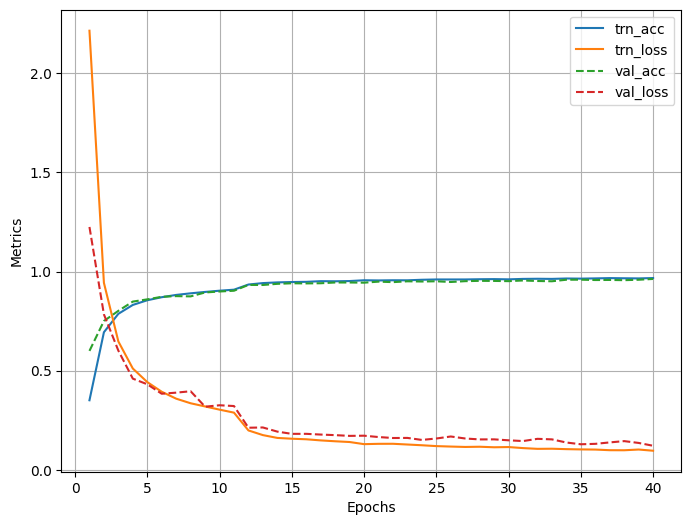

[10/04/24 03:04:10] INFO     Dumped object of size ≈2 MB @ "no-aug-no-bn.log" in 1.59e+00 seconds                       ]8;id=427134;file://<ipython-input-11-6f71284d6602>:164\<ipython-input-11-6f71284d6602>]8;;\:<cell line: 164>:164

» no-aug-no-bn.log

In [ ]:
from torch_snippets import *
from torch.optim import Adam
classIds = pd.read_csv('signnames.csv')
classIds.set_index('ClassId', inplace=True)
classIds = classIds.to_dict()['SignName']
classIds = {f'{k:05d}':v for k,v in classIds.items()}
id2int = {v:ix for ix,(k,v) in enumerate(classIds.items())}

#Assign the class IDs to possible output classes:
from torchvision import transforms as T
classIds = pd.read_csv('signnames.csv')
classIds.set_index('ClassId', inplace=True)
classIds = classIds.to_dict()['SignName']
classIds = {f'{k:05d}':v for k,v in classIds.items()}
id2int = {v:ix for ix,(k,v) in enumerate(classIds.items())}

# Define the transformation pipeline on top of the images without any augmentation
from torchvision import transforms as T
trn_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(32),
    T.CenterCrop(32),
    #The commented part of the code is what we should uncomment and re-run to understand the scenario of performing data augmentation
    # T.ColorJitter(brightness=(0.8,1.2),
    # contrast=(0.8,1.2),
    # saturation=(0.8,1.2),
    # hue=0.25),
    # T.RandomAffine(5, translate=(0.01,0.1)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

val_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(32),
    T.CenterCrop(32),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

#Define the GTSRB dataset class
class GTSRB(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, files, transform=None):
        self.files = files
        self.transform = transform
        logger.info(len(self))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, ix):
        try:
            fpath = self.files[ix]
            clss = fname(parent(fpath))
            img = read(fpath, 1)
            return img, classIds[clss]
        except:
            Warn(f'Missing {fpath}. Loading a different image')
            return self[randint(len(self))]

    def choose(self):
        return self[randint(len(self))]

    def collate_fn(self, batch):
        imgs, classes = list(zip(*batch))
        if self.transform:
            imgs = [self.transform(img)[None] for img in imgs]
        classes = [torch.tensor([id2int[clss]]) for clss in classes]
        imgs, classes = [torch.cat(i).to(device) for i in [imgs, classes]]
        return imgs, classes

# Create the training and validation datasets and data loaders
device = 'cuda' if torch.cuda.is_available() else 'cpu'
all_files = Glob('GTSRB/Final_Training/Images/*/*.ppm')
np.random.seed(10)
np.random.shuffle(all_files)

from sklearn.model_selection import train_test_split
trn_files, val_files = train_test_split(all_files, random_state=1)

trn_ds = GTSRB(trn_files, transform=trn_tfms)
val_ds = GTSRB(val_files, transform=val_tfms)
trn_dl = DataLoader(trn_ds, 32, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, 32, shuffle=False, collate_fn=val_ds.collate_fn)

import torchvision.models as models

def convBlock(ni, no):
    return nn.Sequential(
        nn.Dropout(0.2),
        nn.Conv2d(ni, no, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        #nn.BatchNorm2d(no), # uncomment the line when testing the model with the BatchNormalization scenario
        nn.MaxPool2d(2),
    )

class SignClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            convBlock(3, 64),
            convBlock(64, 64),
            convBlock(64, 128),
            convBlock(128, 64),
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.Dropout(0.2),
            nn.ReLU(inplace=True),
            nn.Linear(256, len(id2int))
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def compute_metrics(self, preds, targets):
        ce_loss = self.loss_fn(preds, targets)
        acc = (torch.max(preds, 1)[1] == targets).float().mean()
        return ce_loss, acc

# Define the functions to train and validate on a batch of data
def train_batch(model, data, optimizer, criterion):
    ims, labels = data
    _preds = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_preds, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    ims, labels = data
    _preds = model(ims)
    loss, acc = criterion(_preds, labels)
    return loss.item(), acc.item()

# Define the model and train it over increasing epochs
model = SignClassifier().to(device)
criterion = model.compute_metrics
optimizer = Adam(model.parameters(), lr=1e-3)
n_epochs = 40

log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')

    log.report_avgs(ex+1)
    if ex == 10: optimizer = Adam(model.parameters(), lr=1e-4)

log.plot_epochs()
dumpdill(log, 'no-aug-no-bn.log')

# **Practical aspects to take care of during model implementation**

Practical considerations that need to be taken care of when building models in real-world applications, few of them are as following:


*   Imbalanced data
*   The size of an object within an image when performing classification
*   The difference between training and validation images
*   The number of convolutional and pooling layers in a network
*   Image sizes to train on GPUs
*   OpenCV utilities



